In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ng4_7iwh
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ng4_7iwh
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264330 sha256=38a62d66f36c1eff587aa16c98d593102c2478d41ba556e44ecf961b0dfb66ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-_zbll3pn/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

--2022-05-05 10:57:43--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   163MB/s    in 0.3s    

2022-05-05 10:57:43 (163 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-05-05 10:57:43--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-05 10:57:43--
Total wall clock time: 0.4s
Downloaded: 1 files, 51M in 0.3s (163 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

In [ ]:
import numpy as np
from PIL import Image
import os

import torch 
import torch.utils.data as data


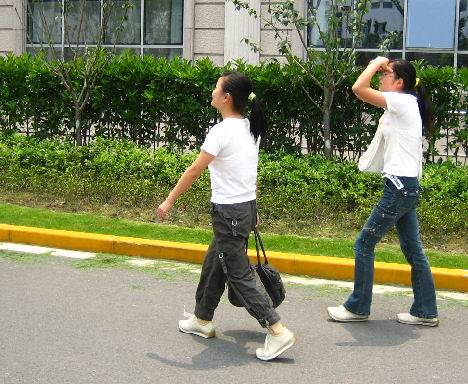

In [ ]:
Image.open('/content/PennFudanPed/PNGImages/FudanPed00012.png')

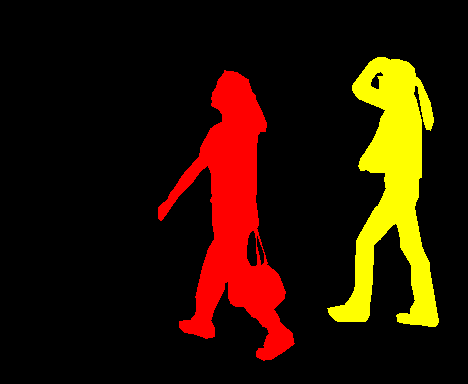

In [ ]:
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00012_mask.png')
# mask = np.array(mask)
mask.putpalette([
                 0, 0, 0,   #black background
                 255, 0, 0,     # index 1 is red
                 255, 255, 0,     # index 2 is yellow
                 255, 153, 0      # index 3 in orange
                 # Here indexes mean the number of objects that are there in the .png file
])
mask

In [15]:
class PennFudanDataset(data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
    self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
    mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
    img = Image.open(img_path).convert('RGB')

    mask = Image.open(mask_path)
    mask = np.array(mask)
    obj_ids  = np.unique(mask)
    obj_ids = obj_ids[1:]
    
    #splitting the color encoded masks into a set of binary masks
    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    #convert everthing into a torch.tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['masks'] = masks
    target['image_ids'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target
  
  def __len__(self):
    return len(self.imgs)

In [16]:
dataset = PennFudanDataset('/content/PennFudanPed')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F73B29708D0>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_ids': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [ ]:
img_path = '/content/PennFudanPed/PNGImages/FudanPed00012.png'
mask_path = '/content/PennFudanPed/PedMasks/FudanPed00012_mask.png'
# img = Image.open(img_path).convert('RGB')
# img
mask = Image.open(mask_path)  
mask = np.array(mask)

obj_ids = np.unique(mask) #checking uniques values in mask array
obj_ids = obj_ids[1:]     #first id (0) represents black, hence it is removed
# print(obj_ids)
masks = mask = obj_ids[:, None, None]
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
  pos = np.where(mask[i])
  xmin = np.min(pos[1])
  xmax = np.max(pos[1])
  ymin = np.min(pos[0])
  ymax = np.max(pos[0])
  boxes.append([xmin, ymin, xmax, ymax])
boxes = torch.as_tensor(boxes, dtype=torch.float32)
#there is only one class, i.e. pedestrian
labels = torch.ones((num_objs,), dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)

# print(boxes)
# print('---')
# print(labels)
# print('---')
# print(masks)


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
---
tensor([1, 1])
---
tensor([[[1]],

        [[2]]], dtype=torch.uint8)
